In [1]:
!pip install einops -qq
!pip install tensorflow_datasets -qq
!pip install tensorflow-text -qq

In [2]:
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams
import zipfile

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/saurabh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saurabh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
def get_data(path='./dataset/flickr8k'):
    """
    Downloads and extracts the Flickr8k dataset and text files.

    Parameters:
        path (str): Path where the dataset will be stored.
    """
    path = pathlib.Path(path)
    
    # Download and extract the Flickr8k Dataset
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True
    )
    
    # Download and extract the Flickr8k text files
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True
    )

def get_dataset(path='./dataset/flickr8k'):
    """
    Reads and processes the Flickr8k dataset to create training and testing datasets.

    Parameters:
        path (str): Path where the dataset is stored.

    Returns:
        tuple: A tuple of training and testing datasets.
    """
    path = pathlib.Path(path)
    
    # Read and process captions
    captions = (path / 'Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    
    # Create a dictionary of image paths and their respective captions
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)
    
    # Read training and testing image paths
    train_imgs_path = (path / 'Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path / 'Flickr_8k.testImages.txt').read_text().splitlines()
    
    # Create training and testing datasets
    train_caps = [
        (str(path / 'Flicker8k_Dataset' / img_path), cap_dict[img_path]) 
        for img_path in train_imgs_path
    ]
    test_caps = [
        (str(path / 'Flicker8k_Dataset' / img_path), cap_dict[img_path]) 
        for img_path in test_imgs_path
    ]
    
    # Convert to TensorFlow datasets
    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [5]:
get_data()
train_raw, test_raw = get_dataset() # Use path='flickr8k' if on windows

In [6]:
# Global configurations
image_shape = (224, 224, 3)
vocab_size = 5000
batch_size = 64

# Feature extractor model
feature_extractor = tf.keras.applications.MobileNetV3Small(
    input_shape=image_shape, include_preprocessing=True, include_top=False
)
feature_extractor.trainable = False

In [7]:
# Helper function to load and preprocess images
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

# Standardize captions: lowercase, remove punctuation, add [START] and [END]
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# Create TextVectorization layer
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

# Create mappings between text tokens and IDs
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

# Serialize data: duplicate image features for each caption
def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ... -> (b c) ...', c=captions_shape['c'])
    return images, captions

# Prepare batches: tokenize captions into input-output pairs
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]
    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

# Save preprocessed dataset to disk
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards=20, batch_size=64):
    raw_ds = (
        raw_ds.map(lambda img_path, cap: (load_img(img_path), cap), tf.data.AUTOTUNE)
        .batch(batch_size)
    )

    def gen():
        for (img, cap) in tqdm(raw_ds):
            img_features = image_feature_extractor(img)
            img_features, cap = serialize_data(img_features, cap)
            yield img_features, cap

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=image_feature_extractor.output_shape),
            tf.TensorSpec(shape=(None,), dtype=tf.string),
        ),
    )

    ds = (
        ds.map(prepare_batch, tf.data.AUTOTUNE)
        .unbatch()
        .shuffle(1000)
    )

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func=shard_func)

def load_dataset(file_path, batch_size = 64, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [8]:
%%time
save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

train_ds = load_dataset('train_cache', batch_size)
test_ds = load_dataset('test_cache', batch_size)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 1min 4s, sys: 18.5 s, total: 1min 22s
Wall time: 57.9 s


In [9]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [10]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [11]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2

vocab = vectorizer.get_vocabulary()
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.517193191416238
curr_entropy : 5.292547935444457


In [12]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

CPU times: user 37.5 ms, sys: 7.57 ms, total: 45 ms
Wall time: 102 ms


In [13]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [14]:
for img_path, caps in train_raw.take(1):
    break

img = load_img(img_path)
caps = [cap.numpy().decode('utf-8') for cap in caps]

In [15]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])
callbacks = [GenerateText(), tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]


In [17]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 2,
    callbacks = callbacks
)

Epoch 1/2


/Users/saurabh/Documents/projects/caption-lens/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'causal_attention' (of type CausalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saurabh/Documents/projects/caption-lens/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saurabh/Documents/projects/caption-lens/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'feed_forward' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support maskin



Generated_text: a rock, 	 f_score: 0
━━ 0s 181ms/step - loss: 5.1297 - masked_accuracy: 0.1643 

/Users/saurabh/Documents/projects/caption-lens/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Generated_text: a black dog is a dog and a man in the to a a in a dog a man, 	 f_score: 0.4375
Generated_text: a water, 	 f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - loss: 5.1284 - masked_accuracy: 0.1646 - val_loss: 4.6809 - val_masked_accuracy: 0.2324
Epoch 2/2


Generated_text: a dog is, 	 f_score: 0
Generated_text: a person in a dog with a dog, 	 f_score: 0
Generated_text: a dog is and a black dog is plays in blue is is, 	 f_score: 0
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 4.7003 - masked_accuracy: 0.2440 - val_loss: 4.3825 - val_masked_accuracy: 0.2675


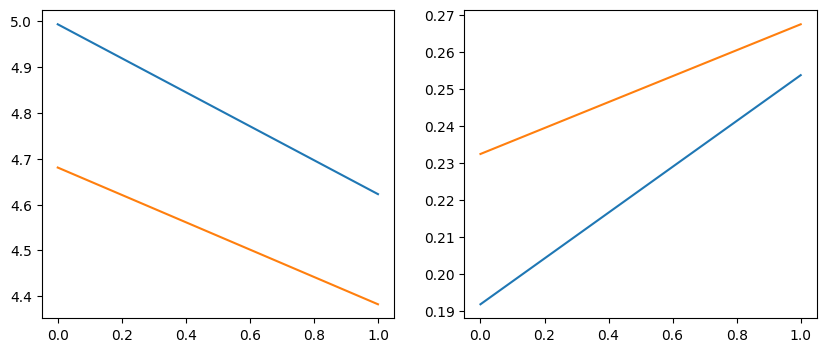

In [18]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

In [47]:
@Captioner.add_method
def show_attention(self, img, temperature=0.5):
    """
    Visualizes the attention maps for the generated caption.

    Args:
        img: Input image as a tensor.
        temperature: Sampling temperature for text generation.

    Returns:
        None
    """
    # Generate text using the captioning model
    gen_text = self.generate_text(img=img[tf.newaxis, ...], temperature=temperature)  # Adjusted generate_text call
    cap_gen_tokens = gen_text.split() + ['[END]']  # Add [END] to match token generation
    
    # Get attention scores from the decoder
    attn_scores = self.decoder.last_attention_scores  # Shape: (batch, num_heads, seq_len, h*w)
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', 
                              h=7, w=7, reduction='mean')  # Average across heads
    
    # Ensure lengths align between tokens and attention maps
    len_result = min(len(attn_maps), len(cap_gen_tokens))  # Use the shorter length
    col_len = int(np.ceil(len_result / 2))  # Number of columns for subplot grid
    row_len = 2  # Number of rows for subplot grid

    # Plot the image with attention maps for each token
    plt.figure(figsize=(15, 5))
    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i + 1)
        img_plot = ax.imshow(img / 255)  # Normalize image for display
        plt.title(cap_gen_tokens[i])  # Add token as the title
        ax.imshow(attn_maps[i], cmap='gray', alpha=0.6, 
                  extent=img_plot.get_extent(), 
                  clim=[0, np.max(attn_maps[i])])  # Overlay attention map
        plt.axis('off')  # Remove axes

    plt.tight_layout()
    plt.show()


Enter the image path:  download.jpeg


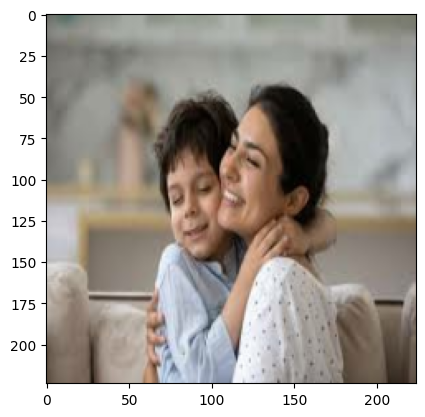

Generated Caption: a man in a group a a inline in the in a woman with a a is on the


In [48]:
img_path = input("Enter the image path: ")
img = load_img(img_path)
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

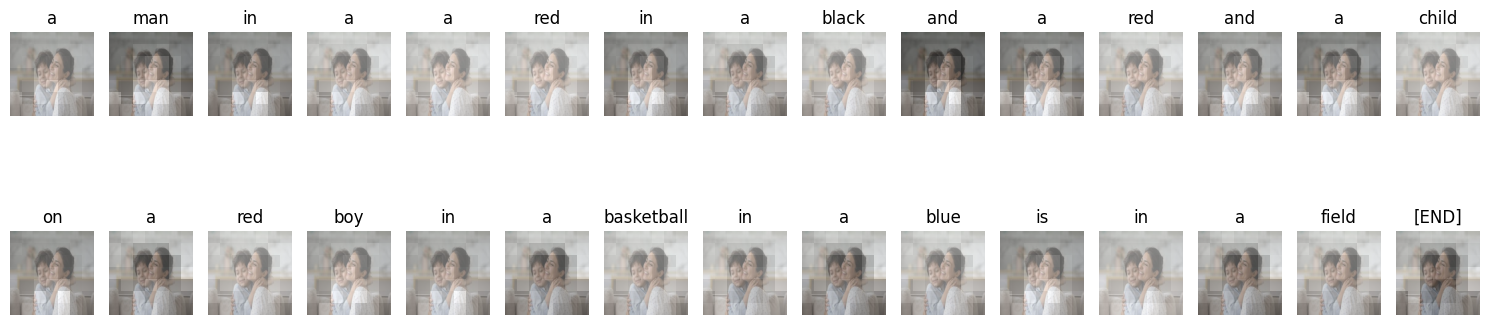

In [53]:
captioner_model.show_attention(img)